In [ ]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from scipy.linalg import block_diag
import statsmodels.api as sm
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm

fldr = os.path.abspath(os.path.join(os.getcwd(), '..'))
trn_start_dt = datetime(1926, 12, 31)  # Training start
bt_start_dt = datetime(2002, 12, 31)  # Backtest start
bt_end_dt = datetime(2019, 3, 31)  # Backtest end
freq = 'W-Fri'

In [ ]:
# Fama-French factors
rt_ff = pd.read_pickle(f'{fldr}/data/ff.pkl')
rt_ff = rt_ff.add(1).cumprod().apply(np.log).diff().dropna(how='all')
rt_ff = rt_ff.dropna().groupby(pd.Grouper(freq=freq)).sum()
rf = rt_ff['rf']
rt_ff.drop(['rf'], axis=1, inplace=True)

# Stock returns
rt = pd.read_pickle(f'{fldr}/data/rt_sp.pkl')
first_obs = rt.apply(pd.Series.first_valid_index)
last_obs = rt.apply(pd.Series.last_valid_index)
rt = rt.groupby(pd.Grouper(freq=freq)).sum()
aux = np.repeat(rt.index.values.reshape(-1, 1), rt.shape[1], axis=1)
aux = pd.DataFrame(aux, index=rt.index, columns=rt.columns)
flags_first = aux >= first_obs
flags_last = aux <= last_obs
rt = rt.where(flags_first & flags_last)
er = rt.sub(rf, axis=0).dropna(how='all')  # Excess return

# S&P meta data
is_tradable = pd.read_pickle(f'{fldr}/data/is_tradable_sp.pkl')
meta = pd.read_pickle(f'{fldr}/data/meta_sp.pkl')

Model is not converging.  Current: 34802.7358324844 is not greater than 34802.99905901606. Delta is -0.26322653165698284


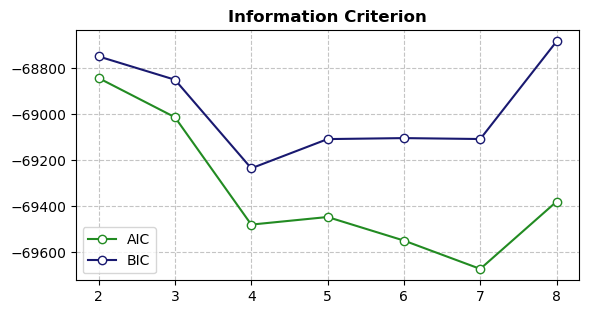

In [ ]:
factor_set = ['mktrf', 'smb', 'hml']
trn = rt_ff.loc[trn_start_dt:bt_start_dt, factor_set]  # Training set
X = trn.values

states_to_try = range(2, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
for n in states_to_try:
    mdl = GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
    mdl.fit(X)
    bic[n] = mdl.bic(X)
    aic[n] = mdl.aic(X)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])

Model is not converging.  Current: 34802.73583248588 is not greater than 34802.99905901493. Delta is -0.26322652905219


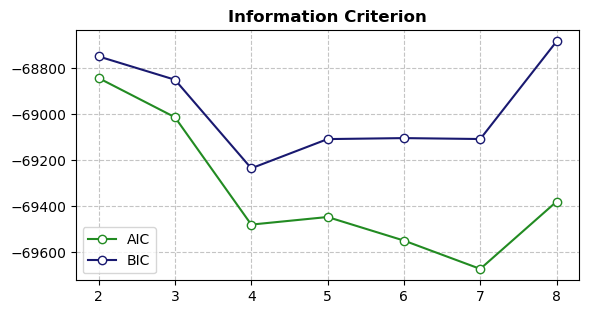

In [ ]:
factor_set = ['mktrf', 'smb', 'hml', 'umd']
trn = rt_ff.loc[trn_start_dt:bt_start_dt, factor_set]  # Training set
X = trn.values

states_to_try = range(2, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
for n in states_to_try:
    mdl = GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
    mdl.fit(X)
    bic[n] = mdl.bic(X)
    aic[n] = mdl.aic(X)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])

For the sake of this exercise I'm using a static insample regime modeling. I will compar later how this compares with an out-of-sample exercise.

In [62]:
m = 4
factor_set = ['mktrf', 'smb', 'hml', 'umd']

trn = rt_ff.loc[trn_start_dt:bt_end_dt, factor_set]  # Training set
X = trn.values
mdl = GaussianHMM(n_components=m, covariance_type="full", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
mdl.fit(X)

# Emmission probabilities matrix
Gamma = mdl.predict_proba(trn)
mu_s = mdl.means_
Sigma_s = mdl.covars_
B = mdl.transmat_

# Results tables
cols = pd.MultiIndex.from_tuples([('State-dependent means', x) for x in trn.columns])
table_means = pd.DataFrame(mdl.means_, columns=cols)
table_means.index.name = 'Hidden State'
display(table_means.mul(52).apply(lambda x: x.map('{:.2%}'.format)))

print('\n')
cols = pd.MultiIndex.from_tuples([('State-dependent volatilities', x) for x in trn.columns])
table_vols = pd.DataFrame([np.diag(mdl.covars_[i]) for i in range(m)], columns=cols).apply(np.sqrt)
table_vols.index.name = 'Hidden State'
display(table_vols.mul(np.sqrt(52)).apply(lambda x: x.map('{:.2%}'.format)))

print('\nTransition Matrix')
# cols = pd.Index.from_tuples([('State-dependent volatilities', x) for x in trn.columns])
df = pd.DataFrame(B, columns=range(m))
df.index.name = 'Hidden State'
display(df.apply(lambda x: x.map('{:.2%}'.format)))

State-dependent means                         
                             mktrf     smb     hml      umd
Hidden State                                               
0                          -22.71%   1.07%  15.69%  -46.74%
1                           -7.70%  -2.26%  17.88%  -15.17%
2                           15.84%   2.98%   0.81%   13.78%
3                            0.08%  -2.06%  -0.95%   14.40%

State-dependent volatilities                        
                                    mktrf     smb     hml     umd
Hidden State                                                     
0                                  43.14%  23.05%  28.27%  37.19%
1                                  17.77%   9.99%  11.37%  13.63%
2                                   9.52%   5.64%   5.31%   6.26%
3                                  18.29%   9.30%   9.22%  14.57%


Transition Matrix


,0,1,2,3
Hidden State,,,,
0,80.40%,1.78%,0.68%,17.14%
1,0.20%,65.13%,34.43%,0.24%
2,0.02%,8.18%,90.14%,1.66%
3,4.93%,0.00%,3.08%,92.00%


In [63]:
rebalance_dts = pd.date_range(bt_end_dt - pd.DateOffset(months=1), bt_end_dt, freq='BM')

fetch_theta = {}

dt = rebalance_dts[0]

# for dt in rebalance_dts:
tradable_names = is_tradable.columns[is_tradable.xs(dt)]
R = er.loc[trn_start_dt:dt, tradable_names]
R = R.iloc[:, :10]  ##############################################
for sec_id in tqdm(R.columns, desc=dt.strftime('%b-%d-%Y')):
    r = R[sec_id].dropna()
    Z = sm.add_constant(trn.reindex(r.index))
    k = Z.shape[1]
    M = block_diag(*[Z] * m)
    delta = block_diag(*[r.values.reshape(-1, 1)] * m)
    Gamma_t = pd.DataFrame(Gamma, index=trn.index).reindex(r.index).values
    gamma_t = Gamma_t[-1]
    Omega = np.diag(Gamma_t.flatten('F'))
    I = np.concatenate([np.eye(k)] * m, axis=1)
    Theta = I @ np.linalg.inv(M.T @ Omega @ M) @ M.T @ Omega @ delta  # Regime-dependent betas
    theta_t = Theta @ B.T @ gamma_t.reshape(-1, 1)

    fetch_theta[(dt, sec_id)] = pd.Series(theta_t.flatten(), index=Z.columns)

Feb-28-2019:   0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
is_tradable

,10006.0,10030.0,10049.0,10057.0,10078.0,10102.0,10104.0,10107.0,10108.0,10137.0,...,92988.0,93002.0,93089.0,93096.0,93132.0,93159.0,93246.0,93422.0,93429.0,93436.0
1926-01-31,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1926-02-28,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1926-03-31,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1926-04-30,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1926-05-31,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,False,False,False,False,False,False,True,True,False,False,...,False,True,True,True,True,False,False,False,True,True
2021-09-30,False,False,False,False,False,False,True,True,False,False,...,False,True,True,True,True,False,False,False,True,True
2021-10-31,False,False,False,False,False,False,True,True,False,False,...,False,True,True,True,True,False,False,False,True,True
2021-11-30,False,False,False,False,False,False,True,True,False,False,...,False,True,True,True,True,False,False,False,True,True
